https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

# time-series-forecasting-wiki
This repository tries to encapsulate the basics of time series forecasting. I will talk through the basics of time series analysis and give an overview of the most efective methods I have encountered for both Univariate and Multivariate series.

Table of contents
=================
* [0 Requirements](#requirements) 
* [1 Time Series](#time-series)
* [2 Preparing our dataset](#sample-datasets)
* [3 Time series analysis, visualization and preprocessing methods](#extra-data-visualization-and-preprocessing-methods)
  * 3.1  Decomposing time series
  * 3.2  Seasonality
    * 3.2.1 Automatic seasonality modelling #REVIEW
    * 3.2.2 Manual methods to model our series seasonality
  * 3.3  Stationarity  
    * 3.3.1  Autocorrelation and Partial autocorrelation
    * 3.3.2  Plotting Rolling Statistics
  	* 3.3.3  Dickey-Fuller Test
  * 3.4  Making Time Series Stationary
	* 3.4.1  Transformations
	  * 3.4.1.1  Log Scale Transformation
	  * 3.4.1.2  Other possible transformations:
	* 3.4.2  Techniques to remove Trend - Smoothing
	  * 3.4.2.1  Moving Average
	  * 3.4.2.2  Exponentially weighted moving average:
	* 3.4.3  Further Techniques to remove Seasonality and Trend
	  * 3.4.3.1  Differencing
	  * 3.4.3.2  Decomposition
  * 3.5  Filters and noise removal
  * 3.6  Model selection
* [4  Evaluation metrics](#evaluation-metrics)
* [5  Univariate Time Series forecasting](#univariate-time-series-forecasting)
  * 5.1 Basis
    * 5.1.1  Autoregression (AR)
      * Reversing the transformations
      * Forecast quality scoring metrics
    * 5.1.2 Moving Average (MA)
  * 5.2 Linear Models
    * 5.2.1  Autoregressive Moving Average (ARMA)
    * 5.2.2  Autoregressive Integrated Moving Average (ARIMA)
    * 5.2.3  Autoregressive Fractionally Integrated Moving Average (ARFIMA)
    * 5.2.4  Seasonal Autoregressive Integrated Moving-Average (SARIMA) + (SARIMAX)
  * 5.3 Non-Linear Models
    * 5.3.1  Autoregressive conditional heteroskedasticity (ARCH)
  * 5.4 Other
    * 5.4.1  Auto - ARIMA
  	* 5.4.2  Auto - SARIMA
  	* 5.4.3  Tuned - SARIMA
  * 5.5  Interpreting ACF and PACF plots
  * 5.6  Improving Time Series Forecast models
  * 5.7  Solve a problem!
  
* [8  Multivariate Time Series Forecasting](multivariate-time-series-forecasting)
    * 8.1 Non-Linear Models
        * 8.1.1 Prophet
        * 8.1.2 Neural Networks
    

* [9 Additional resources & literature](#additional-resources-and-literature)
  



In [1]:
#Download the required python libraries executing this cell
!pip install -r requirements.txt

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import statsmodels.tsa.api as smt
import statsmodels as sm

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from pylab import rcParams




#Extra settings
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'


Using TensorFlow backend.
/Users/jafen/anaconda3/envs/timeseries/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jafen/anaconda3/envs/timeseries/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jafen/anaconda3/envs/timeseries/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/j

# 2 - The dataset

We will be using the [Beijing air quality dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv) containing an air pollution measurement from 2011 to 2014. The dataset also contains extra weather features such as wind speed, wind direction or even if its raining. Measurements are /hour but we will group them into daily measurements for simplicity. Special thanks to Jason Brownlee for publishing it in his github and his webpage https://machinelearningmastery.com/.

The file is downloaded and preprocessed in our [script](https://github.com/jiwidi/time-series-forecasting-wiki/blob/master/datasets/download_datasets.py) on the dataset folder. After #EXPLAIN PROCESSING

The resulting file contains the following columns:

* date
* pollution_today
* dew
* temp
* press
* wnd_spd
* snow
* rain
* pollution_tomorrow




In [3]:
#Execute the script to download and process the dataset by running this cell
!python datasets/download_datasets.py

INFO:__main__:Processing air pollution dataset
/Users/jafen/anaconda3/envs/time/lib/python3.8/site-packages/urllib3/connectionpool.py:997: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:__main__:Saving air pollution dataset to/Users/jafen/Documents/github/time-series-forecasting-wiki/datasets
INFO:__main__:Air pollution dataset processed
INFO:__main__:Processing done


### Load the dataset and quick preview

In [4]:
air_pollution = pd.read_csv('datasets/air_pollution.csv',parse_dates=['date'])
air_pollution.set_index('date',inplace=True)
air_pollution.head() #Preview our dataset

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_tomorrow
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,78.833333
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,31.333333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,42.458333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,56.416667
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,69.000000


In [5]:
air_pollution.describe()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_tomorrow
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,98.245080,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,98.245080
std,76.807697,14.163508,11.552997,10.076053,41.373161,0.546072,0.993917,76.807697
min,3.166667,-33.333333,-14.458333,994.041667,1.412500,0.000000,0.000000,3.166667
25%,42.333333,-10.083333,1.541667,1007.916667,5.904167,0.000000,0.000000,42.333333
50%,79.166667,2.041667,13.916667,1016.208333,10.953750,0.000000,0.000000,79.166667
75%,131.166667,15.083333,23.166667,1024.541667,22.235000,0.000000,0.000000,131.166667
max,541.895833,26.208333,32.875000,1043.458333,463.187917,14.166667,17.583333,541.895833


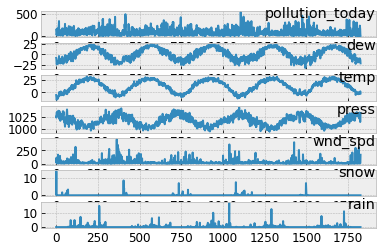

In [6]:
values = air_pollution.values
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(air_pollution.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

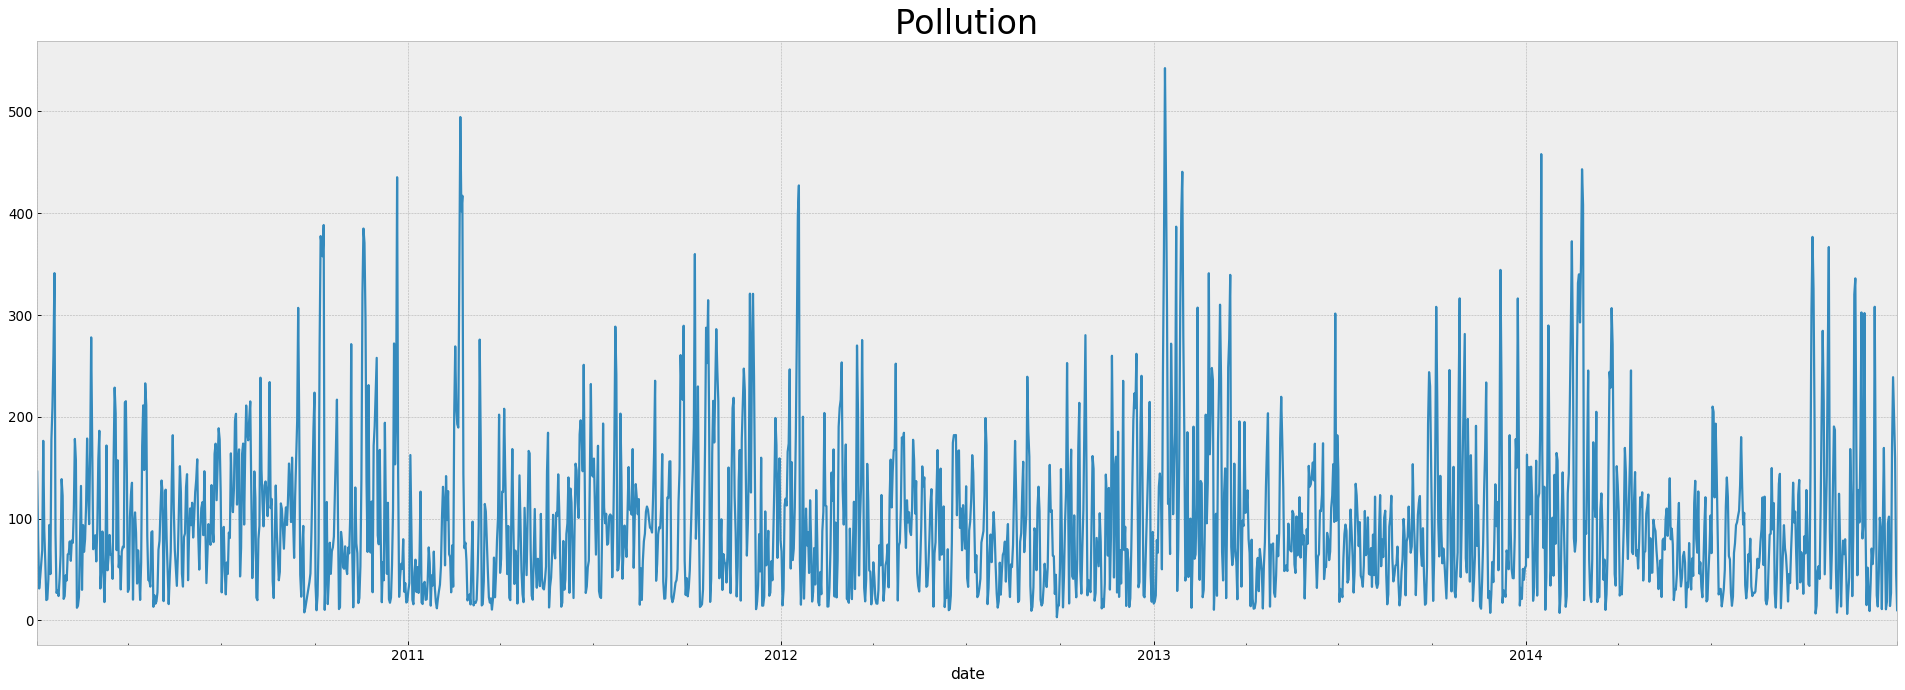

In [7]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Pollution',fontsize=30)

air_pollution.pollution_today.plot()

# 3 - Time series basic analysis

## 3.1 - Decomposing our time series

One of the most common analysis for time series is decomposing it into multiple parts. The parts we can divide a time series into are: level, trend, seasonality and noise, all series contain level and noise but seasonality and trend are not always present (there will be more analysis for this two parts).

This 4 parts can combine either additively or multiplicatively into the time series.

##### Additive Model
`y(t) = Level + Trend + Seasonality + Noise`

Additives models are lineal. Trend is linear and seasonality has constant frequency and amplitude. Change is constant over time
   
##### Multiplicative model
`y(t) = Level * Trend * Seasonality * Noise`

Multiplicatives models are nonlinear,trend is curved and seasonality is not constant. Change is not constant over time

Decomposing is used to analyse the time series. Identify each one of the different parts of the time series and its behaviour, each of the components may affect your models in different ways. 

Most time series are a combination of a additive model and a multiplicate model, is hard to identify real world time series into one single model. 

##### Automatic time series decomposition

Statsmodel python library provides a function [seasonal_compose()](http://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) to automatically decompose a time series, you still need to specify wether the model is additive or multiplicative. We will use multiplicative as our quick peak at the pm2.5 time series shows no linear trend.

<Figure size 4000x1600 with 0 Axes>

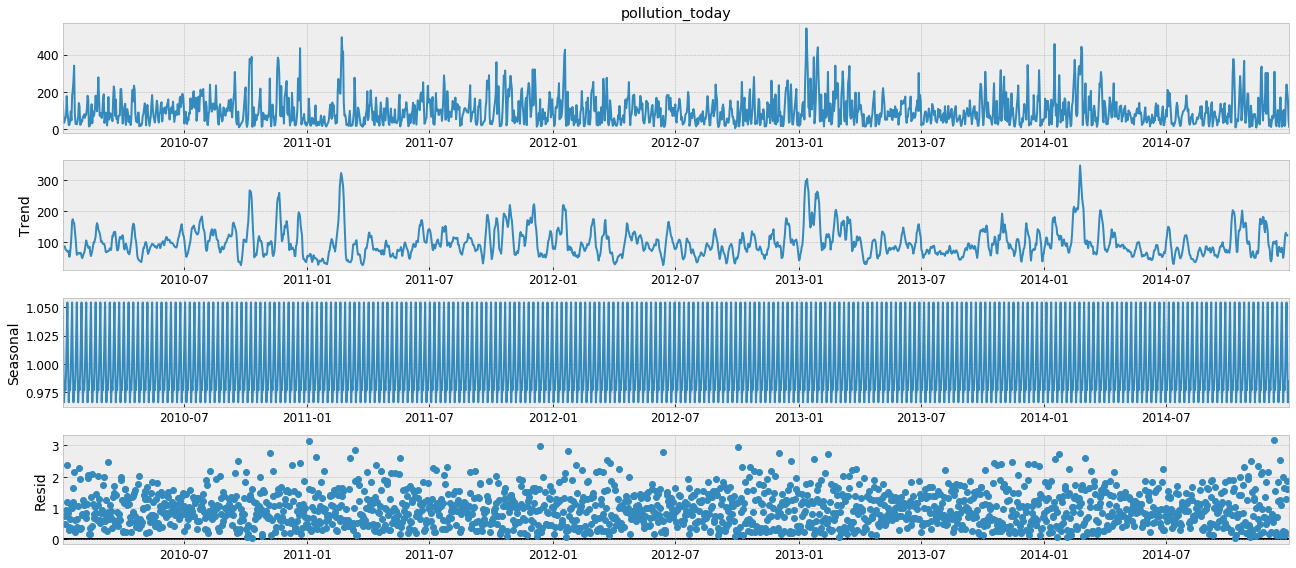

In [8]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

## 3.2 - Seasonality
We just saw how Seasonality can be one of the most determinants components of a time series. Seasonalities show periodic fluctiations that repeat over time. For example the amount of sunscream protector (always low in winter and high in summer).

The previous chart did not gave us a good look into the decomposed seasonality, let's try decomposing smaller parts of the time series first and test seasonalities we found into the others.

Lets go with the first year of data only now:

<Figure size 4000x1600 with 0 Axes>

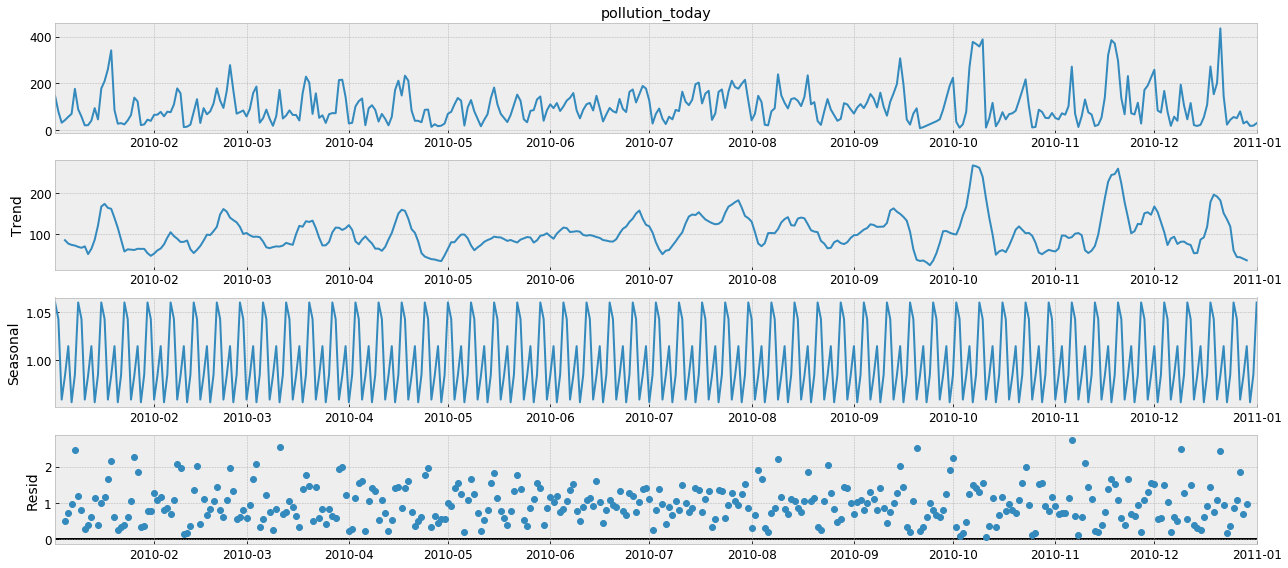

In [9]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

Here can see a clear weekly trend, 4 spikes every month, lets check how the last year of data looks

<Figure size 4000x1600 with 0 Axes>

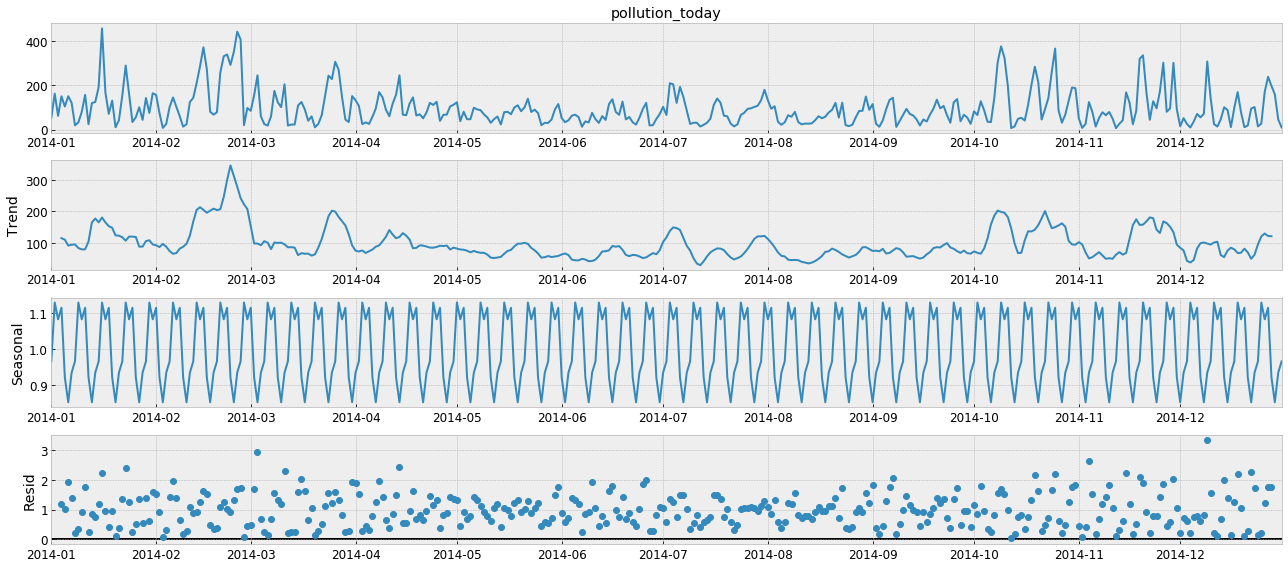

In [10]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[-365:]
result = seasonal_decompose(series, model='multiplicative')
result.plot()
pass

We see another weekly seasonality(4 spikes between every month) but a bit different to the original one, this is something we should always expect from real datasets as their seasonalities will never be perfect but a combination of multiples.

##INTERPRETATION

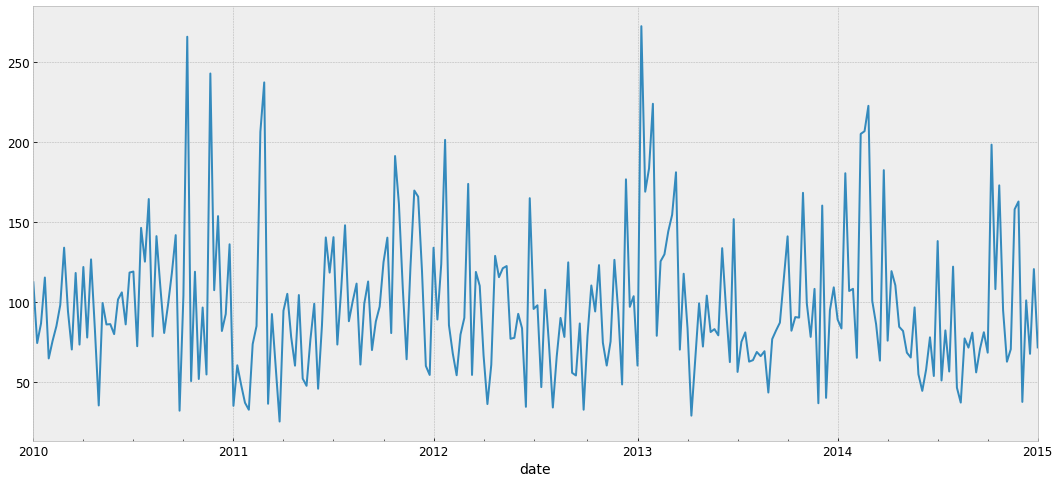

In [11]:
#Looking for monthly seasonality
resample = air_pollution.resample('W')
monthly_mean = resample.mean()
monthly_mean.pollution_today.plot()

#### 3.2.2 - Manual methods to find seasonalities

/Users/jafen/anaconda3/envs/timeseries/lib/python3.6/site-packages/numpy/lib/polynomial.py:629: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/jafen/anaconda3/envs/timeseries/lib/python3.6/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/jafen/anaconda3/envs/timeseries/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


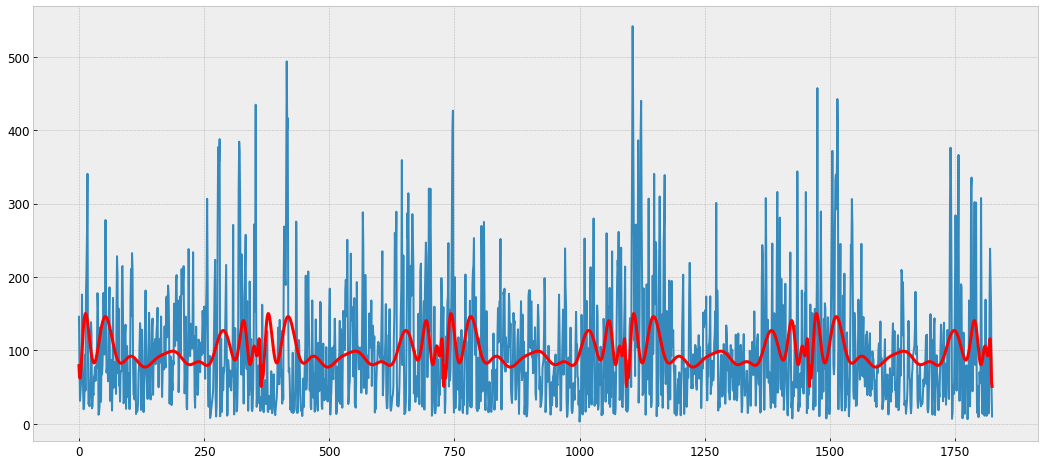

In [12]:
#Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = air_pollution.pollution_today.values
X = [i%365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series)
plt.plot(curve, color='red', linewidth=3)
plt.show()

We can see how the model to find a seasonality fits poorly to our data. Is going to be a complicate time series to model :P 

## 3.3 - Stationarity
Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different ways.

Often, stock prices are not a stationary process, since we might see a growing trend, or its volatility might increase over time (meaning that variance is changing).

### Check for sationarity




#### Autocorrelation and Partial autocorrelation plots

Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n.

Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.

If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time


#EXPLAIN AUTOCORRELATION

<Figure size 1296x576 with 0 Axes>

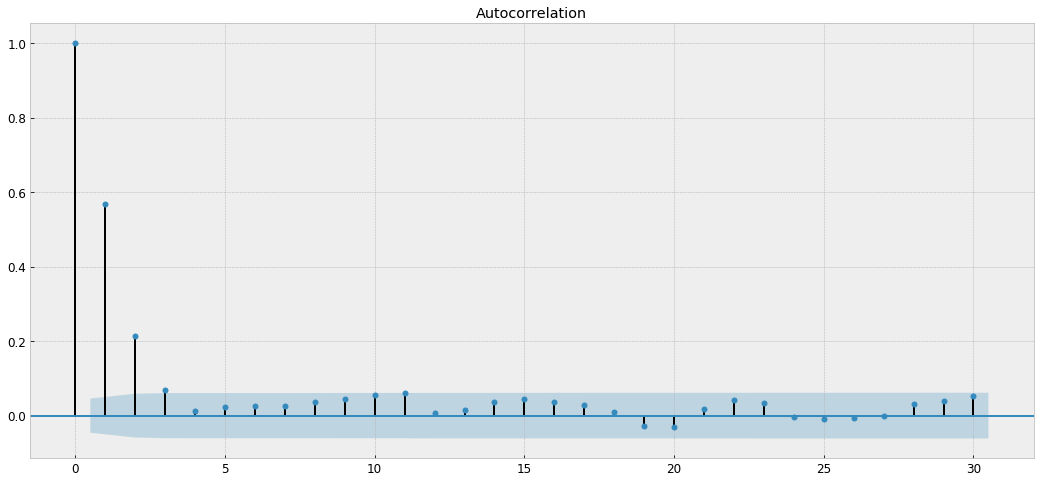

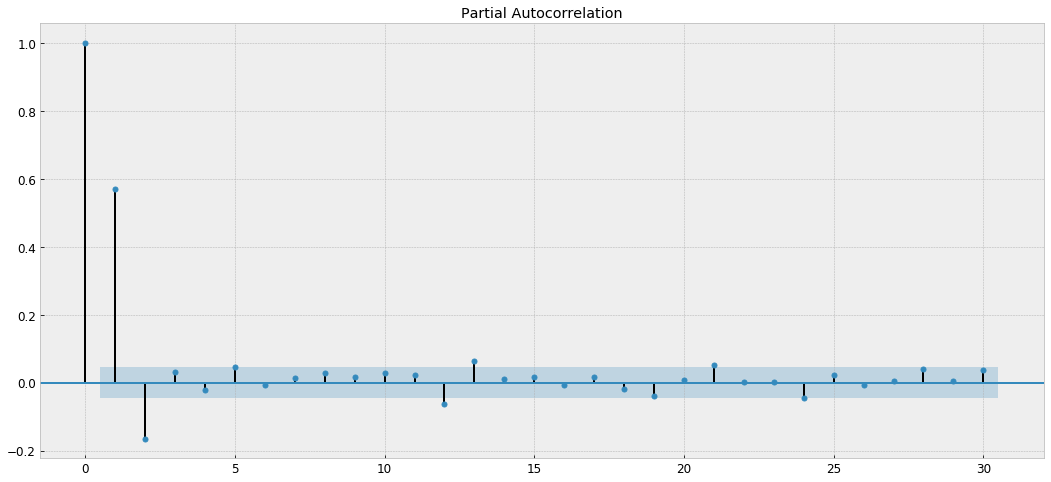

In [13]:
plt.figure()
plot_acf(series, lags = 30)
plot_pacf(series, lags = 30)
plt.show()

We saw that our time series values are not correlated with distant points in time, this is good and shows us our series should be stationary but for the shake of learning and confirming we will test with some other methods

#### Rolling means and std of our series

We were talking about how our mean and standard deviation should be constant over time in order to have a stationary time series, why not just plot this two properties?

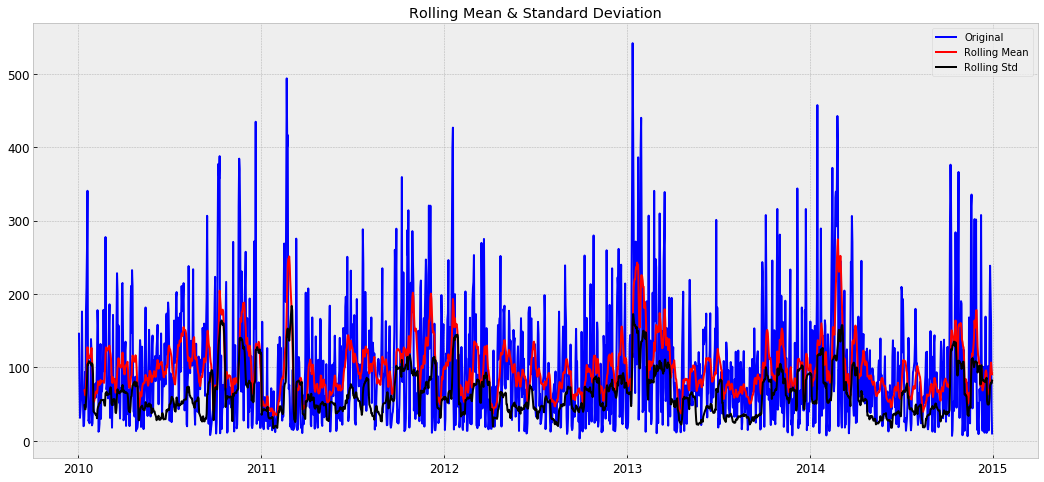

In [15]:
#Determing rolling statistics
rolmean = air_pollution.pollution_today.rolling(window=12).mean()
rolstd = air_pollution.pollution_today.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(air_pollution.pollution_today, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

We can see how our mean and standar deviation have a constant behaviour over the years, even if they change over the year this behaviour is then repeated next year. This proves us again a stationary series

#### Augmented Dickey-Fuller test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
Below is an example of calculating the Augmented Dickey-Fuller test on the Daily Female Births dataset. The statsmodels library provides the adfuller() function that implements the test.


In [16]:

X = air_pollution.pollution_today.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.116719
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Here we also provide a method to quickly perform all the previous methods into one single function call and a pretty graph :) 

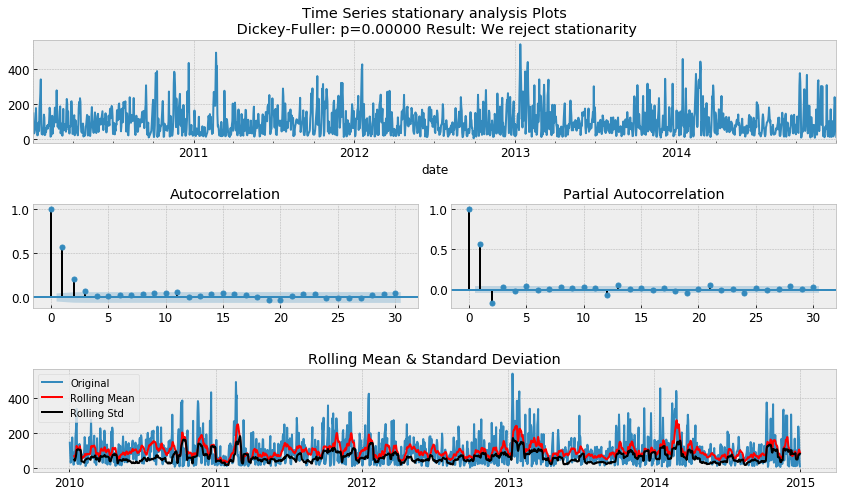

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        mean_std_ax = plt.subplot2grid(layout, (2,0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value<=0.05 else "We can not reject stationarity"
        ts_ax.set_title('Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value,hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
        rolmean = air_pollution.pollution_today.rolling(window=12).mean()
        rolstd = air_pollution.pollution_today.rolling(window=12).std()

        #Plot rolling statistics:
        orig = plt.plot(air_pollution.pollution_today,label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        
        
tsplot(air_pollution.pollution_today, lags=30)

##  3.4  Making Time Series Stationary

##ADD ROLLING MEAN AND ROLLING STD TO ALL CHARTS MUDAFAKAAA

Okay we got lucky with this dataset and is already stationary, but what happens when this is not the case? We included a dummy dataset called `international_airline_passengers.csv` on the datasets folders which is not stationary and we will apply some methods in this section to transform it into a stationary series.

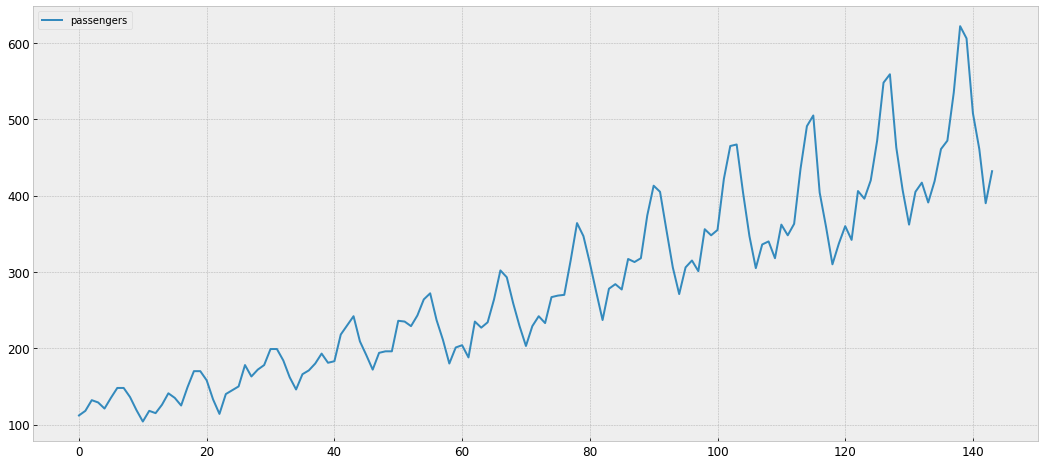

In [21]:
passengers = pd.read_csv("datasets/international_airline_passengers.csv")
passengers.plot()

Lets run our stationary multitest function over this series

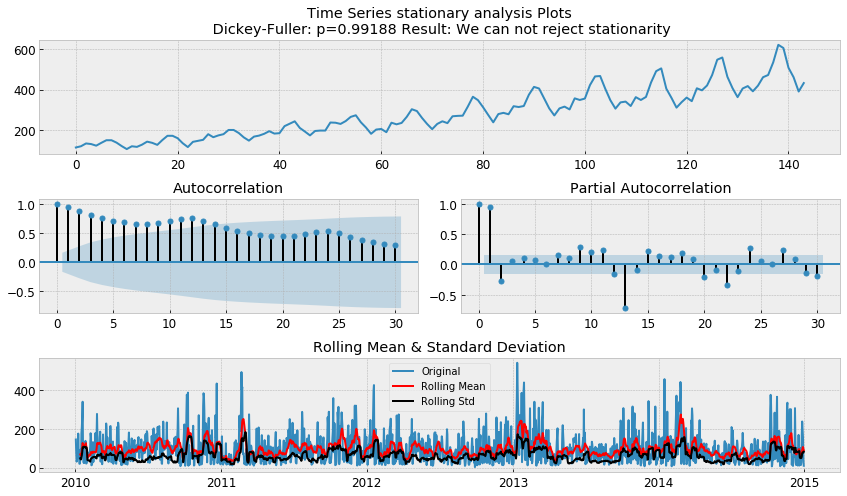

In [22]:
tsplot(passengers.passengers, lags=30)

With a p value of ~1 and high correlation values over time distant samples we need to apply some methods to make the series stationary.

Coming back to the stationary definition, what makes our current series non stationary?

* **Trend** - The mean for our series is not constant, it increases over time

* **Seasonality** - The values of our series vary over time with an specific pattern that repeats over time, this is called seasonalities (spike of people flying on the 24th of December)

Mainly we need to make our mean values as constant as possible and remove seasonalities, we now present some methods to achieve it.

### 3.4.1 - Difference transform

Applying a difference transform to a time series could help remove the series dependence on time.

This transform is done by substracting the previous obesvation to the current one.

`difference(t) = observation(t) - observation(t-1)`

Taking the difference between consecutive observations would be a lag-1 difference, we can tweek this lag value to fit our series.

We can also apply differencing transforms consecutively in the same series if the temporal effect hasnt been removed yet. This is called multiple order difference transform

In [24]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset=diff
    return diff

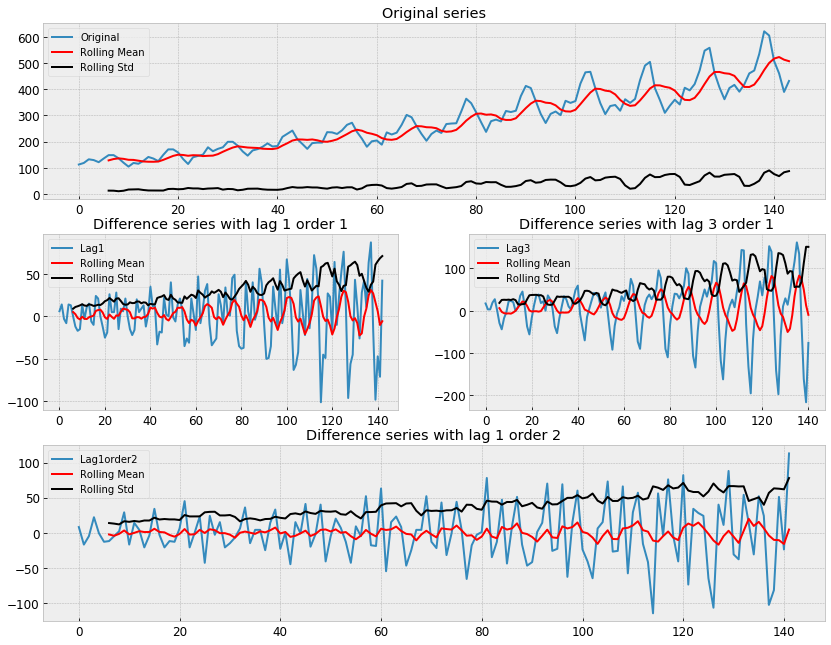

In [57]:
lag1series = pd.Series(difference(passengers.passengers, interval=1, order=1))
lag3series = pd.Series(difference(passengers.passengers, interval=3, order=1))
lag1order2series = pd.Series(difference(passengers.passengers, interval=1, order=2))

fig = plt.figure(figsize=(14,11))
layout = (3,2)
original = plt.subplot2grid(layout, (0,0), colspan=2)
lag1 = plt.subplot2grid(layout, (1,0))
lag3 = plt.subplot2grid(layout, (1,1))
lag1order2 = plt.subplot2grid(layout, (2,0), colspan=2)

original.set_title('Original series')
original.plot(passengers.passengers, label = 'Original')
original.plot(passengers.passengers.rolling(7).mean(), color='red', label='Rolling Mean')
original.plot(passengers.passengers.rolling(7).std(), color='black', label = 'Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label = "Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label = 'Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label = "Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label = 'Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label = "Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(), color='black', label = 'Rolling Std')
lag1order2.legend(loc='best')

We can see how 1 order differencing doesnt really remove stationary but once we go with a order 2 difference it looks closer to a stationary series

### 3.4.2  - Log scale transformation

### 3.4.3 - Smoothing

### 3.4.4 - Moving average

  

# Evaluation Metrics

There are many measures that can be used to analyze the performance of a prediction:

* Geometric Mean Absolute Error (GMAE)
* Geometric Mean Relative Absolute Error (GMRAE)
* Integral Normalized Root Squared Error (INRSE)
* Mean Absolute Error (MAE) / Mean Absolute Deviation (MAD)
* Mean Absolute Percentage Error (MAPE)
* Mean Absolute Scaled Error (MASE)
* Mean Arctangent Absolute Percentage Error (MAAPE)
* Mean Bounded Relative Absolute Error (MBRAE)
* Mean Directional Accuracy (MDA)
* Mean Error (ME)
* Mean Percentage Error (MPE)
* Mean Relative Absolute Error (MRAE)
* Mean Relative Error (MRE)
* Mean Squared Error (MSE)
* Median Absolute Error (MDAE)
* Median Absolute Percentage Error (MDAPE)
* Median Relative Absolute Error (MDRAE)
* Normalized Absolute Error
* Normalized Absolute Percentage Error
* Normalized Root Mean Squared Error (NRMSE)
* Relative Absolute Error (RAE)
* Root Mean Squared Error (RMSE)
* Root Mean Squared Percentage Error (RMSPE)
* Root Mean Squared Scaled Error (RMSSE)
* Root Median Squared Percentage Error (RMSPE)
* Root Relative Squared Error (RRSE)
* Symmetric Mean Absolute Percentage Error (MAPE)
* Symmetric Median Absolute Percentage Error (SMDAPE)
* Unscaled Mean Bounded Relative Absolute Error (UMBRAE)



# Additional resources and literature
## Papers

|| |
| - | - |
| Adhikari, R., & Agrawal, R. K. (2013). An introductory study on time series modeling and forecasting.|[[1]](https://arxiv.org/ftp/arxiv/papers/1302/1302.6613.pdf)|

# Pytorch

In [71]:
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    def forward(self, input, future=0, y=None):
        outputs = []
        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

    from torch.autograd import Variable
    
    
def transform_data(arr, seq_len):
    x, y = [], []
    for i in range(len(arr) - seq_len):
        x_i = arr[i : i + seq_len]
        y_i = arr[i + 1 : i + seq_len + 1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = Variable(torch.from_numpy(x_arr).float())
    y_var = Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var
seq_len = 100

x_train, y_train = transform_data(train, seq_len)
x_val, y_val = transform_data(test, seq_len)
x_test, y_test = transform_data(test, seq_len)

# LSTM Keras

In [68]:
values = air_pollution.values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = pd.DataFrame(scaler.fit_transform(air_pollution[['pollution_today', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']]),columns=['pollution_today', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain'])
reframed["pollution_tomorrow"] = air_pollution["pollution_tomorrow"].values
# frame as supervised learning
print(reframed.head())

   pollution_today       dew      temp     press   wnd_spd  snow  rain  \
0         0.265053  0.417075  0.197183  0.621417  0.050777  0.05   0.0   
1         0.140454  0.389783  0.125000  0.581788  0.150561  1.00   0.0   
2         0.052284  0.209237  0.062500  0.713322  0.237666  0.00   0.0   
3         0.072934  0.146956  0.000000  0.801012  0.120205  0.00   0.0   
4         0.098844  0.161652  0.040493  0.803541  0.037029  0.00   0.0   

   pollution_tomorrow  
0           78.833333  
1           31.333333  
2           42.458333  
3           56.416667  
4           69.000000  


In [69]:


# split into train and test sets
values = reframed.values
n_train_hours = 1500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1500, 1, 7) (1500,) (325, 1, 7) (325,)


In [ ]:
# design network
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [ ]:

# make a prediction
yhat = model.predict(test_X)
yhat = yhat.reshape(len(yhat))

inv_y = test_y
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:


mean = air_pollution.pollution_tomorrow.mean()
mean_guess = [mean for u in range(len(air_pollution.pollution_tomorrow.values))]

mse_guess = sqrt(mean_squared_error(air_pollution.pollution_tomorrow.values,mean_guess))
print(f"MSE with a dummy mean guess {mse_guess}")